In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import random

In [5]:
def intmatrix(Lx, J, xs=1, ys=1, theta=0, phi=0, Ly='_'):
    # define side length of simulated system as L
    if Lx % 2 == 1:
        pass
    else:
        Lx += 1

    if Ly == '_':
        Ly = Lx
    else:
        if Ly % 2 == 1:
            pass
        else:
            Ly += 1
    
    mat = np.zeros((Lx, Ly))
    
    L_xrange, L_yrange = range(Lx), range(Ly)
    center_xindex = int(L_xrange[-1]/2)
    center_yindex = int(L_yrange[-1]/2)
    
    
    center = np.array([xs*center_xindex, ys*center_yindex, 0]) #position of matrix center (in 3D)
    
    quan_axis = [np.cos(theta)*np.sin(phi), np.sin(theta)*np.sin(phi), np.cos(phi)] #quantization axis as an unit vector
    
    
    for i in L_xrange:
        for j in L_yrange:
            displacement = np.array([xs*i, ys*j, 0]) - center
            r = np.linalg.norm(displacement)
            angle = np.arccos(displacement @ quan_axis/r)
            mat[i, j] = J*(1-3*(np.cos(angle)**2))/(r**3)
    mat[center_xindex, center_yindex] = 0.0
    
    return mat, Lx, Ly #indexing interaction matrix is done with mat[x coordinate, y coordinate]



/var/folders/ln/c_qknrr51xbgxcyyp59605kr0000gn/T/ipykernel_528/1964664335.py:32: RuntimeWarning: invalid value encountered in scalar divide
  angle = np.arccos(displacement @ quan_axis/r)


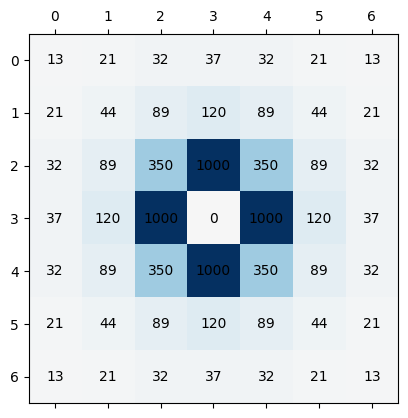

In [7]:
fig, ax = plt.subplots()

Lx, Ly, J = 7, 7, 1000
theta, phi = 0, 0

mat, xside, yside = intmatrix(Lx, J, Ly=Ly, theta=theta, phi=phi)
couplings = np.transpose(mat)

cmap = plt.cm.RdBu
ax.matshow(couplings, cmap=cmap, norm=colors.CenteredNorm())

for i in range(len(couplings)):
    for j in range(len(couplings[0])):
        c = '{:g}'.format(float('{:.2g}'.format(couplings[i, j])))
        ax.text(j, i, str(c), va='center', ha='center')
plt.savefig(f'interaction_matrix.pdf', bbox_inches='tight')

In [8]:
def ran_occupied_sites(N, interactions):
    x, y = (len(interactions)+1) / 2, (len(interactions[0])+1) / 2 #dimensions of simulated lattice
    total_sites = int(x*y)

    # Randomize which lattice sites are occupied
    occupied_sites = []
    free_sites = list(range(total_sites))
    
    for i in range(N):
        ran = random.randint(0, total_sites-i-1)
        #print('random int = ' + str(ran))
        occupied_sites.append(free_sites.pop(ran))
        
    return sorted(occupied_sites) #returns ordered list of N unique numbers between 0 and the total sites - 1 inclusive


print(ran_occupied_sites(5, mat))

[10, 11, 12, 14, 15]


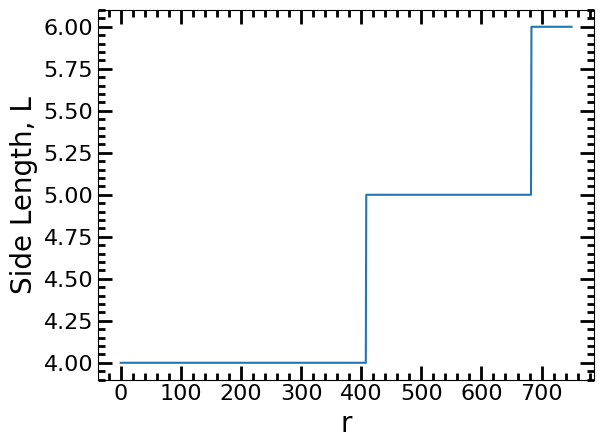

In [11]:
N = 12
p_max, r_max = 0.90, 1000
rs = random.randint(0, int(3*r_max/4))
#p = p_max*(1 - (r/r_max)**2)
#L = np.sqrt(p/N)
################

rs1 = np.linspace(0, 3*r_max/4, 1000)

ps1 = []
Ls = []
for r in rs1:    
    p = p_max*(1 - (r/r_max)**2)
    ps1.append(p)
    L = np.sqrt(N/p)
    Ls.append(int(L)+1)

fig, axes = plt.subplots(1, 1)

axes.plot(rs1, Ls)
        
    #for i in range(5):
        #print(populations[:,1][100*i])

axes.set_ylabel(r"Side Length, L", fontsize=20)
axes.set_xlabel('r', fontsize=20)

axes.minorticks_on()
axes.tick_params(which='major', length=10, width=2, direction='in', bottom=True, top=True, left=True, right=True)
axes.tick_params(which='minor', length=5, width=2, direction='in', bottom=True, top=True, left=True, right=True)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)

plt.savefig(f'system_L_sampling_1000.pdf', bbox_inches='tight')
plt.show(block=False)

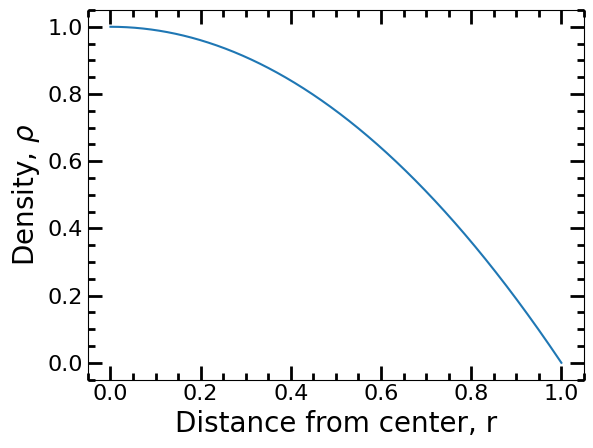

In [35]:
p_max, r_max = 1, 1
rs = np.linspace(0, r_max, 1000)

ps = []
for r in rs:    
    p = p_max*(1 - (r/r_max)**2)
    ps.append(p)


fig, axes = plt.subplots(1, 1)

axes.plot(rs, ps)
        
    #for i in range(5):
        #print(populations[:,1][100*i])

axes.set_ylabel(r"Density, $\rho$", fontsize=20)
axes.set_xlabel('Distance from center, r', fontsize=20)

axes.minorticks_on()
axes.tick_params(which='major', length=10, width=2, direction='in', bottom=True, top=True, left=True, right=True)
axes.tick_params(which='minor', length=5, width=2, direction='in', bottom=True, top=True, left=True, right=True)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)

plt.savefig(f'system_p_sampling.pdf', bbox_inches='tight')
plt.show(block=False)

In [481]:
def couplings(sites, pairs, interactions):
    int_x, int_y = len(interactions), len(interactions[0]) #dimensions of interaction matrix

    #use interaction matrix to get couplings between each occupied site and output this in the correct formatt with particle number
    couples = []
    for i in pairs:
        p1, p2 = sites[i[0]], sites[i[1]]
        couples.append([interactions[int_x//2 + (p1 % int_x) - (p2 % int_x), int_y//2 + (p1 // int_x) - (p2 // int_x)], i[0], i[1]]) 
    return couples

In [489]:
def symm_mat(x, y, occupied_sites, basis, axis=1): #defult finds mirror plane transformation which flips x coordinates
    #only relevent if lattice simulated has the symmetry which is tested on basis staes
    #occupied sites labelled left to right up to down in basis
    #for rectangular simulated systems (but sites occupied can be picked)

    symm = np.zeros((len(basis), len(basis)))
    count1 = 0
    asymmetrics = []
    flips = []
    for i in basis:
        basis_on_lattice = np.zeros((x, y))
        count2 = 0
        for n in i:
            if n == 1:
                basis_on_lattice[occupied_sites[count2] % x, occupied_sites[count2] // x] = 1

            count2 += 1

        flipped = np.flip(basis_on_lattice, axis)
        
        
        if flipped == basis_on_lattice:
            symm[count1, count1] = 1
        else:
            asymmetrics.append(basis_on_lattice)
            flips.append(flipped)
        count1 += 1

    for state in asymmetrics:
        pair = np.where(flips == state)[0]
        symm[pair[0], pair[1]], symm[pair[1], pair[0]] = 1, 1

    return symm

In [485]:
a = [[0, 1, 2], [3, 4, 5], [6, 7, 8]]
print(np.flip(a, 1))

[[2 1 0]
 [5 4 3]
 [8 7 6]]
